# Chapter 2: End-to-End Machine Learning Project

**Book:** Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow (3rd Edition)

In [9]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Display settings
pd.options.display.max_columns = 20
pd.options.display.max_rows = 20
np.set_printoptions(precision=4, suppress=True)

# Plot settings
%matplotlib inline
plt.rc('font', size=10)
plt.rc('axes', labelsize=10, titlesize=10)
plt.rc('legend', fontsize=8)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

## Working with Real Data

### Data Repositories
- [OpenML](https://www.openml.org/) - data sets and tasks (*couldn't sign up, try later*)
- [Kaggle](https://kaggle.com/datases)
- [UC Irvine ML Repository](https://archive.ics.uci.edu/datasets) - datasets (e.g. Iris)
- [Amazon's AWS datasets](https://registry.opendata.aws/)
- [TensorFlow datasets](https://www.tensorflow.org/datasets)
  
### Meta portals and lists
- [DataPortals](https://dataportals.org/)
- [Wikipedia's list of ML datasets](https://en.wikipedia.org/wiki/List_of_datasets_for_machine-learning_research)
- [Quora's list](https://www.quora.com/Where-can-I-find-large-datasets-open-to-the-public)
- [Datasets subreddit](https://www.reddit.com/r/datasets/)

### Papers
- https://huggingface.co/papers/trending

## Scikit-Learn Design

**Consistency** - all objects share a consistent and simple interface

- Estimators - any object that can estimate some params based on a dataset
  - estimation is performed by `fit()`
- Transformers - estimators that can also transform dataset
  - transformation is performed by `transform()`
  - estimation + transformation - `fit_transform()`
- Predictors - estimator that can also make prediction
  - prediction is performed by `predict()`
  - measures the quality of predictions by `score()`

**Inspection** - all estimator's hyperparams are accessible via public variables, and learned params via `statistics_`

**Sensible defaults** - reasonable default values for most params

## ML Project Checklist
(full checklist in the book's Appendix A)

1. Frame the problem and look at the big picture
2. Get the data
3. Explore the data
4. Prepare the data
5. Shorlist promising models
6. Fine-Tune the system
7. Present your solution
8. Launch, monitor and maintain

## Frame the problem

- Business Objective - **predict the median housing price** in any district, and feed to another ML system to analyse possible investments
- Dataset - California Housing Prices
- Current solution - manual work and complex rules. Time consuming and with big errors
- Kind of supervision - **supervised**, multiple univariate **regression**, batch learning
- Performance measure - **root mean square error** $\text{RMSE}(\mathbf{X},h) = \sqrt{\frac{1}{m} \sum\limits_{{i=1}}^{{m}}(h(\mathbf{x}^{(i)})) - y^{(i)})^2}$ - **L2 norm**
  - typical for regression problems
  - gives higher weight to large errors
  - in case of many outliers, other option could be **mean absolute error** $\text{MAE}(\mathbf{X},h) = {\frac{1}{m} \sum\limits_{{i=1}}^{{m}}\left|h(\mathbf{x}^{(i)})) - y^{(i)}\right|}$ - **L1 norm**

## Get the Data

### Download the Data

In [10]:
from pathlib import Path
import tarfile
import urllib.request

def load_csv_from_tar(url, tar_file, data_dir, data_filepath):
    tarball_path = data_dir / tar_file
    if not tarball_path.is_file():
        data_dir.mkdir(parents=True, exist_ok=True)  # Create directory if it doesn't exist
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as tarball:
            tarball.extractall(data_dir, filter="data")
    return pd.read_csv(data_dir / data_filepath)

In [11]:
housing_url = "https://github.com/ageron/data/raw/main/housing.tgz"
housing_tar_file = Path("housing.tgz")

data_dir = Path("../../../data/raw/")
housing_data_filepath = "housing/housing.csv"

housing = load_csv_from_tar(housing_url, housing_tar_file, data_dir, housing_data_filepath)

### Look at the Data

In [12]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [13]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Fairly small dataset with **20640 instances**

`total_bedrooms` feature is missing for 207 instances

In [14]:
housing.ocean_proximity.value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

`ocean_proximity` is categorical with 5 different values

The rest is numerical

In [15]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


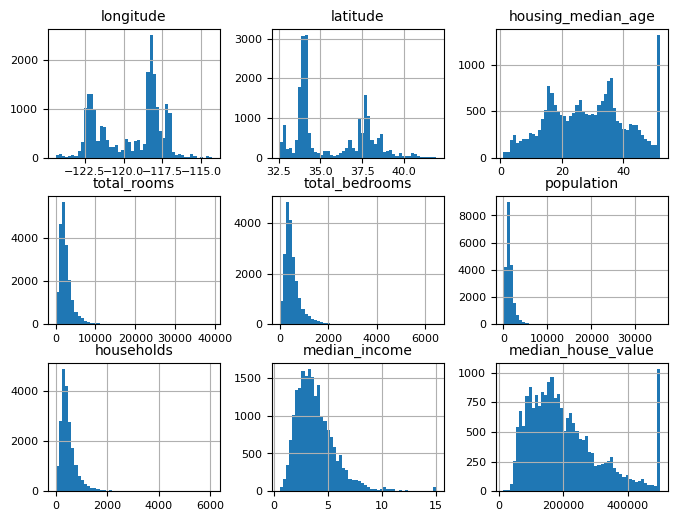

In [16]:
housing.hist(bins=50, figsize=(8, 6))
plt.show()

**Observations**
- `median_income` is expressed in 10000$ and is capped between 0.5-15000
- `median_house_value` - target, is capped 
- `housing_median_age` is capped
- attributes have different scales
- many attributes are skewed

### Create a Test Set

In [17]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

**Stratified sampling** - instances are devided into homogeneous subgroups called *strata*, and the right number of instances sampled from each stratum

Since `median_income` is known to be an important attribute, let's use it for stratified sampling.

In [18]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

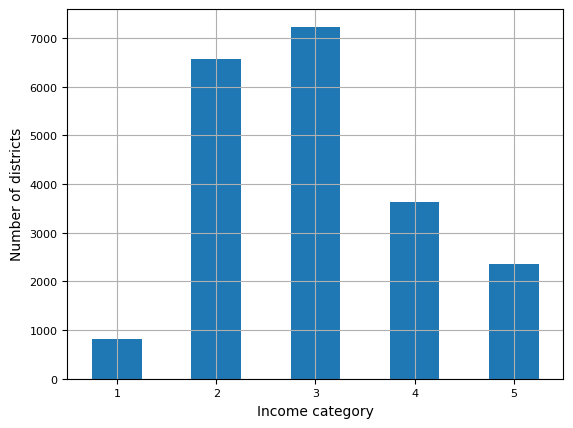

In [19]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [20]:
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

In [21]:
strat_train_set.drop(columns="income_cat", inplace=True)
strat_test_set.drop(columns="income_cat", inplace=True)

## Explore and Visualize the Data

In [22]:
housing = strat_train_set.copy()

### Visualize Geo Data

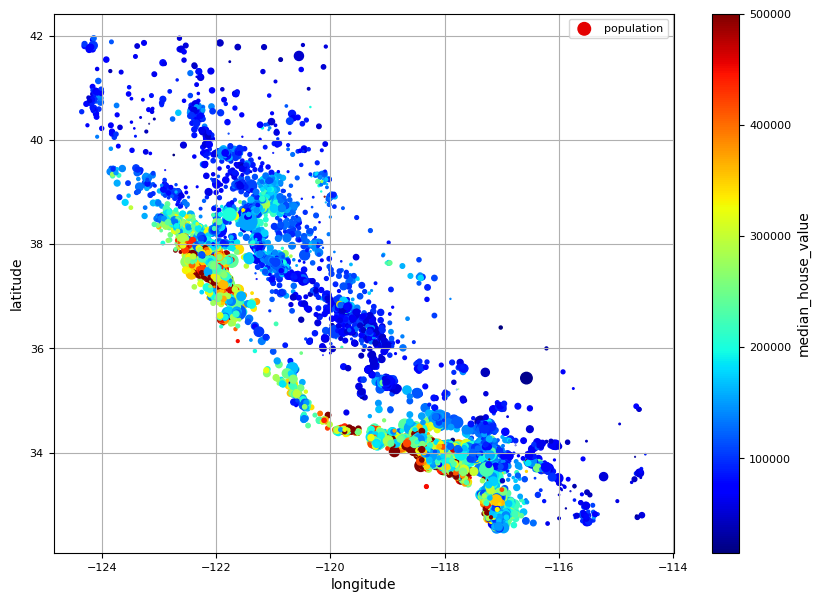

In [23]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing.population / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
plt.show()

Prices are very much related to the location (e.g. close to the ocean) and to the population density.

Clustering algorithm can be used to detect cluster centers and introduce new features.

Ocean promixity could a feature also.

### Look for Correlations

In [24]:
corr_matrix = housing.corr(numeric_only=True)
corr_sorted = corr_matrix.median_house_value.sort_values(ascending=False)
corr_sorted

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

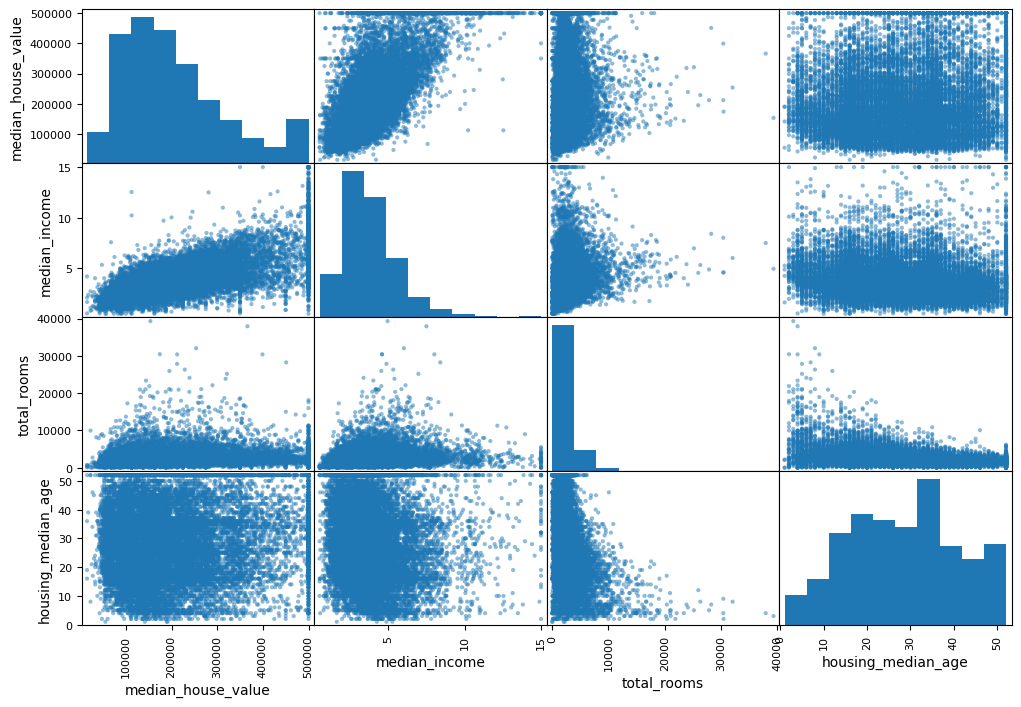

In [25]:
from pandas.plotting import scatter_matrix

top_corr_attributes = corr_sorted.index[:4]
scatter_matrix(housing[top_corr_attributes], figsize=(12, 8))
plt.show()

<Axes: xlabel='median_income', ylabel='median_house_value'>

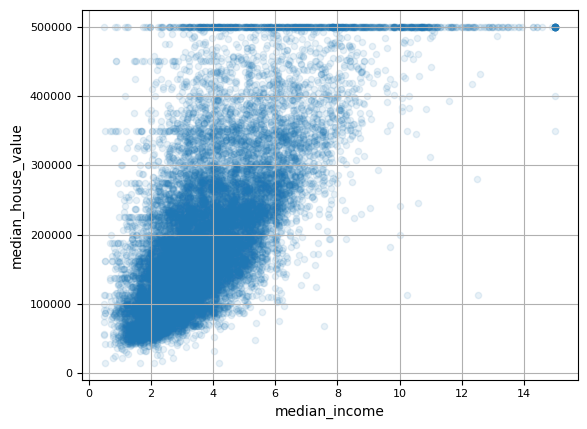

In [26]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, grid=True)

Correlation with `median_income` is strong, and the capped values are clearly seen.

Some strange lines around 350000 and 450000. Might be better to remove them.

### Attribute Combinations

In [27]:
housing["rooms_per_house"] = housing.total_rooms / housing.households
housing["bedrooms_ratio"] = housing.total_bedrooms / housing.total_rooms
housing["people_per_house"] = housing.population / housing.households

In [28]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix.median_house_value.sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

`bedrooms_ratio` and `rooms_per_house` look promising!

## Prepare the Data for Machine Learning

In [29]:
housing = strat_train_set.drop(columns=["median_house_value"])
housing_labels = strat_train_set.median_house_value.copy()

### Clean the Data

Most ML algorithms cannot work with missing features.

Options:
- remove corresponding instances
- remove corresponding attributes
- set the missing values to some value (zero, median, mean, etc.) - **imputation**

In [30]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median") # other options are mean, most_frequent, constant

housing_num = housing.select_dtypes(include=[np.number])
imputer.fit(housing_num)

,"missing_values missing_values: int, float, str, np.nan, None or pandas.NA, default=np.nanThe placeholder for the missing values. All occurrences of`missing_values` will be imputed. For pandas' dataframes withnullable integer dtypes with missing values, `missing_values`can be set to either `np.nan` or `pd.NA`.",nan
,"strategy strategy: str or Callable, default='mean'The imputation strategy.- If ""mean"", then replace missing values using the mean along each column. Can only be used with numeric data.- If ""median"", then replace missing values using the median along each column. Can only be used with numeric data.- If ""most_frequent"", then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.- If ""constant"", then replace missing values with fill_value. Can be used with strings or numeric data.- If an instance of Callable, then replace missing values using the scalar statistic returned by running the callable over a dense 1d array containing non-missing values of each column... versionadded:: 0.20 strategy=""constant"" for fixed value imputation... versionadded:: 1.5 strategy=callable for custom value imputation.",'median'
,"fill_value fill_value: str or numerical value, default=NoneWhen strategy == ""constant"", `fill_value` is used to replace alloccurrences of missing_values. For string or object data types,`fill_value` must be a string.If `None`, `fill_value` will be 0 when imputing numericaldata and ""missing_value"" for strings or object data types.",None
,"copy copy: bool, default=TrueIf True, a copy of X will be created. If False, imputation willbe done in-place whenever possible. Note that, in the following cases,a new copy will always be made, even if `copy=False`:- If `X` is not an array of floating values;- If `X` is encoded as a CSR matrix;- If `add_indicator=True`.",True
,"add_indicator add_indicator: bool, default=FalseIf True, a :class:`MissingIndicator` transform will stack onto outputof the imputer's transform. This allows a predictive estimatorto account for missingness despite imputation. If a feature has nomissing values at fit/train time, the feature won't appear onthe missing indicator even if there are missing values attransform/test time.",False
,"keep_empty_features keep_empty_features: bool, default=FalseIf True, features that consist exclusively of missing values when`fit` is called are returned in results when `transform` is called.The imputed value is always `0` except when `strategy=""constant""`in which case `fill_value` will be used instead... versionadded:: 1.2",False


Only `total_bedrooms` had missing values, but it's safer to apply imputer to all numerical features in case production data will miss some.

In [31]:
imputer.statistics_, housing_num.median().values

(array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
         408.    ,    3.5385]),
 array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
         408.    ,    3.5385]))

In [32]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

### Handling Text and Categorical Attributes

In [33]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head()

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN


In [34]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse_output=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], shape=(16512, 5))

In [35]:
cat_encoder.categories_, cat_encoder.get_feature_names_out()

([array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
        dtype=object)],
 array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
        'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
        'ocean_proximity_NEAR OCEAN'], dtype=object))

In [36]:
housing_encoded = pd.DataFrame(housing_cat_1hot, columns=cat_encoder.get_feature_names_out())
housing_encoded.head()

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0


### Scaling and Transformation

Most ML algorithms don't perform well when numerical attributes have very different scales.

Two common ways to scaling:
- **normalization** (min-max scaling) - shift and scale to fit 0-1 interval
- **standartization** - substract the mean and devide by standart deviation. Does not fit specific range, but less affected by outliers

In [37]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_scaled = std_scaler.fit_transform(housing_num)
pd.DataFrame(housing_num_scaled, columns=housing_num.columns).head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-1.423037,1.013606,1.861119,0.311912,1.359094,0.137460,1.394812,-0.936491
1,0.596394,-0.702103,0.907630,-0.308620,-0.436356,-0.693771,-0.373485,1.171942
2,-1.203098,1.276119,0.351428,-0.712240,-0.759584,-0.788768,-0.775727,-0.759789
3,1.231216,-0.884924,-0.919891,0.702262,0.736231,0.383175,0.731375,-0.850281
4,0.711362,-0.875549,0.589800,0.790125,1.585590,0.444376,1.755263,-0.180365


Most ML algorithms don't like if features's distribution has a lot of far-from-mean values.

Common ways to make distribution more simmetrical:
- replace value with its square root
- replace value with its logarithm
- bucketize the feature - chop distribution into roughly equal-sized buckets, replacing value with the bucket index
- bucketize and encode buckets as categories (if feature has >1 clear peaks - multimodal distribution)
- add separate features for each of the modes (peakes) with similarity between value and the mode

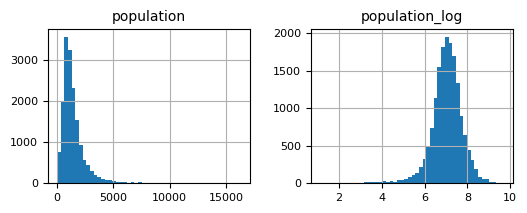

In [38]:
feature_and_log = housing[["population"]].copy()
feature_and_log["population_log"] = np.log(feature_and_log.population)
feature_and_log.hist(bins=50, figsize=(6, 2))
plt.show()

In [39]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

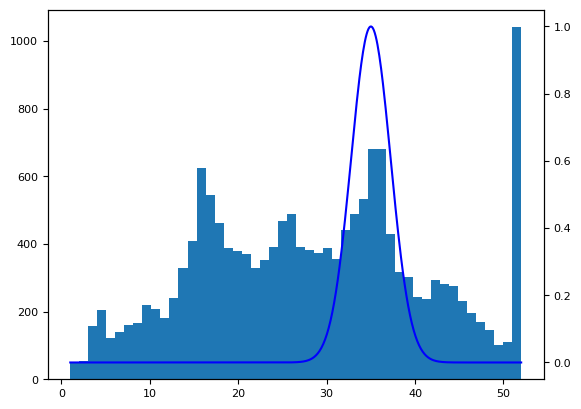

In [40]:
# Visualize
ages = np.linspace(housing["housing_median_age"].min(),
                   housing["housing_median_age"].max(),
                   500).reshape(-1, 1)
gamma1 = 0.1
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)

fig, ax1 = plt.subplots()

ax1.hist(housing["housing_median_age"], bins=50)

ax2 = ax1.twinx()  # create a twin axis that shares the same x-axis
ax2.plot(ages, rbf1, color="blue", label="gamma = 0.10")
plt.show()

If target values need to be transformed, predictions would need to be transformed back.

`inverse_transform` or `TransformedTargetRegressor` could be used for that.

### Custom Transformers

For simple transformation without training, just define a function

In [41]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])

In [42]:
rbf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

For transformer to be trainable, custom class is required

In [43]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        X = check_array(X)

        # fitting
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        
        self.n_features_in_ = X.shape[1]
        return self
    
    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)

        # transform
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [44]:
cluster_simil = ClusterSimilarity(n_clusters=7, gamma=0.7, random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]], sample_weight=housing_labels)
similarities[:3].round(2)

array([[0.  , 0.93, 0.  , 0.  , 0.24, 0.  , 0.16],
       [0.95, 0.  , 0.12, 0.  , 0.  , 0.24, 0.  ],
       [0.  , 0.65, 0.  , 0.  , 0.61, 0.  , 0.32]])

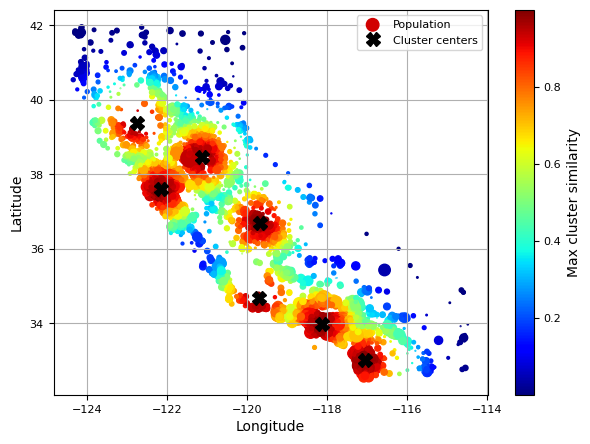

In [45]:
# Visualisation
housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (USD)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(7, 5))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=10,
         label="Cluster centers")
plt.legend(loc="upper right")
plt.show()

### Transformation Pipeline

In [46]:
from sklearn.pipeline import Pipeline

num_pipeline=Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standartize", StandardScaler())
])
num_pipeline

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('impute', ...), ('standartize', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"missing_values missing_values: int, float, str, np.nan, None or pandas.NA, default=np.nanThe placeholder for the missing values. All occurrences of`missing_values` will be imputed. For pandas' dataframes withnullable integer dtypes with missing values, `missing_values`can be set to either `np.nan` or `pd.NA`.",nan
,"strategy strategy: str or Callable, default='mean'The imputation strategy.- If ""mean"", then replace missing values using the mean along each column. Can only be used with numeric data.- If ""median"", then replace missing values using the median along each column. Can only be used with numeric data.- If ""most_frequent"", then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.- If ""constant"", then replace missing values with fill_value. Can be used with strings or numeric data.- If an instance of Callable, then replace missing values using the scalar statistic returned by running the callable over a dense 1d array containing non-missing values of each column... versionadded:: 0.20 strategy=""constant"" for fixed value imputation... versionadded:: 1.5 strategy=callable for custom value imputation.",'median'
,"fill_value fill_value: str or numerical value, default=NoneWhen strategy == ""constant"", `fill_value` is used to replace alloccurrences of missing_values. For string or object data types,`fill_value` must be a string.If `None`, `fill_value` will be 0 when imputing numericaldata and ""missing_value"" for strings or object data types.",None
,"copy copy: bool, default=TrueIf True, a copy of X will be created. If False, imputation willbe done in-place whenever possible. Note that, in the following cases,a new copy will always be made, even if `copy=False`:- If `X` is not an array of floating values;- If `X` is encoded as a CSR matrix;- If `add_indicator=True`.",True
,"add_indicator add_indicator: bool, default=FalseIf True, a :class:`MissingIndicator` transform will stack onto outputof the imputer's transform. This allows a predictive estimatorto account for missingness despite imputation. If

In [47]:
from sklearn.pipeline import make_pipeline

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)
cat_pipeline

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('simpleimputer', ...), ('onehotencoder', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"missing_values missing_values: int, float, str, np.nan, None or pandas.NA, default=np.nanThe placeholder for the missing values. All occurrences of`missing_values` will be imputed. For pandas' dataframes withnullable integer dtypes with missing values, `missing_values`can be set to either `np.nan` or `pd.NA`.",nan
,"strategy strategy: str or Callable, default='mean'The imputation strategy.- If ""mean"", then replace missing values using the mean along each column. Can only be used with numeric data.- If ""median"", then replace missing values using the median along each column. Can only be used with numeric data.- If ""most_frequent"", then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.- If ""constant"", then replace missing values with fill_value. Can be used with strings or numeric data.- If an instance of Callable, then replace missing values using the scalar statistic returned by running the callable over a dense 1d array containing non-missing values of each column... versionadded:: 0.20 strategy=""constant"" for fixed value imputation... versionadded:: 1.5 strategy=callable for custom value imputation.",'most_frequent'
,"fill_value fill_value: str or numerical value, default=NoneWhen strategy == ""constant"", `fill_value` is used to replace alloccurrences of missing_values. For string or object data types,`fill_value` must be a string.If `None`, `fill_value` will be 0 when imputing numericaldata and ""missing_value"" for strings or object data types.",None
,"copy copy: bool, default=TrueIf True, a copy of X will be created. If False, imputation willbe done in-place whenever possible. Note that, in the following cases,a new copy will always be made, even if `copy=False`:- If `X` is not an array of floating values;- If `X` is encoded as a CSR matrix;- If `add_indicator=True`.",True
,"add_indicator add_indicator: bool, default=FalseIf True, a :class:`MissingIndicator` transform will stack onto outputof the imputer's transform. This allows a predictive estimatorto account for missingness despit

In [48]:
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer, make_column_selector

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

preprocessing_simple = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])

# or
# preprocessing_simple = make_column_transformer(
#     (num_pipeline, make_column_selector(dtype_include=np.number)),
#     (cat_pipeline, make_column_selector(dtype_include=object))
# )

preprocessing_simple

,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``feature_name``. e.g. `

In [49]:
housing_prepared = preprocessing_simple.fit_transform(housing)
preprocessing_simple.get_feature_names_out()

array(['num__longitude', 'num__latitude', 'num__housing_median_age',
       'num__total_rooms', 'num__total_bedrooms', 'num__population',
       'num__households', 'num__median_income',
       'cat__ocean_proximity_<1H OCEAN', 'cat__ocean_proximity_INLAND',
       'cat__ocean_proximity_ISLAND', 'cat__ocean_proximity_NEAR BAY',
       'cat__ocean_proximity_NEAR OCEAN'], dtype=object)

**Final Pipeline**

- impute missing numerical values with the median
- impute missing categorical values with most frequent category
- one-hot encode categorical features
- add a few ratio features
- add a few cluster similarity features
- replace features with a long tail with their logarithm
- standartize all numerical features

In [50]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler()
    )

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler()
)

cluster_simil = ClusterSimilarity(n_clusters=7, gamma=0.7, random_state=42)

default_num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

In [51]:
preprocessing = ColumnTransformer([
    ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
    ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
    ("people_per_house", ratio_pipeline(), ["population", "households"]),
    ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population", "households", "median_income"]),
    ("geo", cluster_simil, ["latitude", "longitude"]),
    ("cat", cat_pipeline, make_column_selector(dtype_include=object))
], remainder=default_num_pipeline)

preprocessing

,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('bedrooms', ...), ('rooms_per_house', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",Pipeline(step...ardScaler())])
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``t

In [52]:
housing_prepared = preprocessing.fit_transform(housing)
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'cat__ocean_proximity_<1H OCEAN', 'cat__ocean_proximity_INLAND',
       'cat__ocean_proximity_ISLAND', 'cat__ocean_proximity_NEAR BAY',
       'cat__ocean_proximity_NEAR OCEAN', 'remainder__housing_median_age'],
      dtype=object)

## Select and Train a Model

### Train and Evaluate

In [53]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('columntransformer', ...), ('linearregression', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('bedrooms', ...), ('rooms_per_house', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",Pipeline(step...ardScaler())])
,"sparse_threshold sparse_threshold: fl

In [54]:
lin_housing_predictions = lin_reg.predict(housing)
lin_housing_predictions[:5].round(-2), housing_labels.iloc[:5].values

(array([248400., 376200., 135900.,  99800., 320900.]),
 array([458300., 483800., 101700.,  96100., 361800.]))

In [55]:
from sklearn.metrics import root_mean_squared_error

lin_rmse = root_mean_squared_error(housing_labels, lin_housing_predictions)
lin_rmse

68713.98575878341

Quite a big error - **Underfitting**

In [56]:
lin_reg_simple = make_pipeline(preprocessing_simple, LinearRegression())
lin_reg_simple.fit(housing, housing_labels)

lin_housing_predictions_simple = lin_reg_simple.predict(housing)
lin_rmse_simple = root_mean_squared_error(housing_labels, lin_housing_predictions_simple)
lin_rmse_simple

68232.83515124217

Simple preprocessing apparently performed even better than fancy one!

In [57]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

free_housing_predictions = tree_reg.predict(housing)
tree_rmse = root_mean_squared_error(housing_labels, free_housing_predictions)
tree_rmse

0.0

No error at all - **Overfitting**

### Cross-Validation

In [58]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)
pd.Series(tree_rmses).describe()

count       10.000000
mean     67819.548534
std       2540.218742
min      63832.273946
25%      66291.452422
50%      67928.058900
75%      69950.268090
max      71162.438238
dtype: float64

Small error on tranining set, big error on validation -> confirmed **Overfitting**

### Random Forest

In [59]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forest_reg.fit(housing, housing_labels)

forest_housing_predictions = forest_reg.predict(housing)
forest_rmse = root_mean_squared_error(housing_labels, forest_housing_predictions)
forest_rmse

17711.890073244766

In [60]:
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)
pd.Series(forest_rmses).describe()

count       10.000000
mean     47454.417413
std        986.792478
min      45919.569576
25%      46925.791244
50%      47509.336022
75%      47851.629676
max      49398.241045
dtype: float64

Small error on tranining set, big error on validation -> as well **Overfitting**

## Fine-Tune Your Model

### Grid Search

In [61]:
from sklearn.model_selection import GridSearchCV

forest_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42))
])

param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
     {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]}
]

forest_grid_search = GridSearchCV(forest_pipeline, param_grid, cv=3, scoring="neg_root_mean_squared_error")
forest_grid_search.fit(housing, housing_labels)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","[{'preprocessing__geo__n_clusters': [5, 8, ...], 'random_forest__max_features': [4, 6, ...]}, {'preprocessing__geo__n_clusters': [10, 15], 'random_forest__max_features': [6, 8, ...]}]"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'neg_root_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"verbose verbose: intControls the verbosity

In [62]:
forest_grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [63]:
forest_grid_search_res = pd.DataFrame(forest_grid_search.cv_results_)
forest_grid_search_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
forest_grid_search_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessing__geo__n_clusters,param_random_forest__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
12,2.262580,0.018939,0.074069,0.000153,15,6,"{'preprocessing__geo__n_clusters': 15, 'random...",-43095.751519,-43976.023151,-44872.484379,-43981.419683,725.358190,1
13,2.924126,0.004623,0.074092,0.000435,15,8,"{'preprocessing__geo__n_clusters': 15, 'random...",-43896.387970,-44251.510124,-45168.305267,-44438.734454,535.868837,2
14,3.559797,0.012667,0.074086,0.000897,15,10,"{'preprocessing__geo__n_clusters': 15, 'random...",-44317.240415,-44446.281691,-45237.216980,-44666.913029,406.692234,3
7,2.206487,0.012295,0.076190,0.002431,10,6,"{'preprocessing__geo__n_clusters': 10, 'random...",-44130.410908,-44917.195959,-45579.005867,-44875.537578,592.119585,4
9,2.187734,0.014885,0.073862,0.000887,10,6,"{'preprocessing__geo__n_clusters': 10, 'random...",-44130.410908,-44917.195959,-45579.005867,-44875.537578,592.119585,4


### Randomized Search

In [64]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

forest_rnd_search = RandomizedSearchCV(forest_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
                                scoring="neg_root_mean_squared_error", random_state=42)
forest_rnd_search.fit(housing, housing_labels)

,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'preprocessing__geo__n_clusters': <scipy.stats....t 0x127ebacf0>, 'random_forest__max_features': <scipy.stats....t 0x1310d8e10>}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",10
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'neg_root_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies th

In [65]:
forest_rnd_search.best_params_

{'preprocessing__geo__n_clusters': 45, 'random_forest__max_features': 9}

In [66]:
forest_random_search_res = pd.DataFrame(forest_rnd_search.cv_results_)
forest_random_search_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
forest_random_search_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessing__geo__n_clusters,param_random_forest__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,3.444890,0.006146,0.074276,0.000607,45,9,"{'preprocessing__geo__n_clusters': 45, 'random...",-41318.031440,-42192.125832,-42785.123379,-42098.426884,602.591243,1
8,2.693048,0.009068,0.075570,0.001127,32,7,"{'preprocessing__geo__n_clusters': 32, 'random...",-41722.876860,-42456.252102,-43323.708695,-42500.945886,654.300538,2
5,1.719034,0.014128,0.074185,0.000777,42,4,"{'preprocessing__geo__n_clusters': 42, 'random...",-41825.957394,-42871.496907,-43394.329288,-42697.261196,652.030757,3
0,5.840614,0.034855,0.076018,0.000677,41,16,"{'preprocessing__geo__n_clusters': 41, 'random...",-42595.312634,-42904.474740,-43318.731755,-42939.506376,296.371634,4
2,2.974742,0.002967,0.074716,0.000708,23,8,"{'preprocessing__geo__n_clusters': 23, 'random...",-42512.152705,-43020.002091,-44100.452061,-43210.868952,662.317311,5


### Analyzing the Best Models

In [67]:
forest_best_model = forest_rnd_search.best_estimator_
feature_importances = forest_best_model["random_forest"].feature_importances_
feature_names = forest_best_model["preprocessing"].get_feature_names_out()

sorted(zip(feature_importances, feature_names), reverse=True)

[(np.float64(0.18497860908249447), 'log__median_income'),
 (np.float64(0.07891233031760092), 'cat__ocean_proximity_INLAND'),
 (np.float64(0.06328644153498998), 'bedrooms__ratio'),
 (np.float64(0.05599044552654477), 'rooms_per_house__ratio'),
 (np.float64(0.050559986706433434), 'people_per_house__ratio'),
 (np.float64(0.04444381220404552), 'geo__Cluster 30 similarity'),
 (np.float64(0.026587542005308103), 'geo__Cluster 36 similarity'),
 (np.float64(0.02266384689093393), 'geo__Cluster 9 similarity'),
 (np.float64(0.020909350566810755), 'geo__Cluster 18 similarity'),
 (np.float64(0.020180553265663287), 'geo__Cluster 3 similarity'),
 (np.float64(0.01897633003979605), 'geo__Cluster 32 similarity'),
 (np.float64(0.01683795779229061), 'geo__Cluster 37 similarity'),
 (np.float64(0.016687726191589106), 'geo__Cluster 25 similarity'),
 (np.float64(0.016274036767626218), 'geo__Cluster 35 similarity'),
 (np.float64(0.015224462247098856), 'geo__Cluster 1 similarity'),
 (np.float64(0.0134606298733760

### Evaluate on a Test Set

In [68]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

forest_final_predictions = forest_best_model.predict(X_test)

forest_final_rmse = root_mean_squared_error(y_test, forest_final_predictions)
forest_final_rmse

41544.80353362495

## Launch, Monitor, and Maintain

### Save the Model

In [69]:
import joblib

joblib.dump(forest_best_model, "../../../models/my_california_housing_model.pkl")

FileNotFoundError: [Errno 2] No such file or directory: '../../../models/my_california_housing_model.pkl'

Reloaded model requires all custom classes and functions it relies on

In [ ]:
forest_final_model_reloaded = joblib.load("../../../models/my_california_housing_model.pkl")

---
## Exercises

### Exercise 1 - SVR

Try support vector machine regressor

In [ ]:
from sklearn.svm import SVR

housing_part = housing[:10000]
housing_part_labels = housing_labels[:10000]

svr_reg = make_pipeline(preprocessing, SVR())
svr_reg.fit(housing_part, housing_part_labels)

,steps,"[('columntransformer', ...), ('svr', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('bedrooms', ...), ('rooms_per_house', ...), ...]"
,remainder,Pipeline(step...ardScaler())])
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
svr_predictions = svr_reg.predict(housing_part)
svr_rmse = root_mean_squared_error(svr_predictions, housing_part_labels)
svr_rmse

118618.23845098497

In [ ]:
svr_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("svr", SVR())
])

param_grid =[
    {'svr__kernel': ["linear"],
     'svr__C': [0.01, 0.1, 1, 2]},
     {'svr__kernel': ["rbf"],
     'svr__C': [0.01, 0.1, 1, 2],
     'svr__gamma': [0.01, 0.1, 1, 2]}
]

svr_grid_search = GridSearchCV(svr_pipeline, param_grid, cv=3, scoring="neg_root_mean_squared_error")
svr_grid_search.fit(housing_part, housing_part_labels)

,estimator,"Pipeline(step...svr', SVR())])"
,param_grid,"[{'svr__C': [0.01, 0.1, ...], 'svr__kernel': ['linear']}, {'svr__C': [0.01, 0.1, ...], 'svr__gamma': [0.01, 0.1, ...], 'svr__kernel': ['rbf']}]"
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('bedrooms', ...), ('rooms_per_house', ...), ...]"


In [ ]:
svr_grid_search_rmse = -svr_grid_search.best_score_
svr_grid_search_rmse

np.float64(113090.07494726748)

Much worse results comparing to other models, but it was trained on a lot less data.

### Exersize 2 - SVR random search

Support vector machine regressor random search CV

In [ ]:
from scipy.stats import expon, loguniform

param_distribs = {
    'svr__kernel': ["linear", "rbf"],
    'svr__C': loguniform(20, 200_000),
    'svr__gamma': expon(scale=1.0)
}

svr_rnd_search = RandomizedSearchCV(svr_pipeline, param_distributions=param_distribs, n_iter=50, cv=3,
                                    scoring="neg_root_mean_squared_error", random_state=42)
svr_rnd_search.fit(housing_part, housing_part_labels)

,estimator,"Pipeline(step...svr', SVR())])"
,param_distributions,"{'svr__C': <scipy.stats....t 0x14418ba10>, 'svr__gamma': <scipy.stats....t 0x14418b770>, 'svr__kernel': ['linear', 'rbf']}"
,n_iter,50
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [ ]:
svr_best_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('svr', SVR(C=svr_rnd_search.best_params_["svr__C"],
                gamma=svr_rnd_search.best_params_["svr__gamma"],
                kernel=svr_rnd_search.best_params_["svr__kernel"])),
])

svr_best_pipeline.fit(housing_part, housing_part_labels)
svr_best_prediction = svr_best_pipeline.predict(housing_part)
svr_best_rmse = root_mean_squared_error(svr_best_prediction, housing_part_labels)
svr_best_rmse

45202.34935981435

Much better results with randomized search

### Exersize 3 - SelectFromModel

Try SelectFromModel to select the most important features

In [ ]:
def evaluate_model(model, X, y, return_predictions=False):
    """Fit model and return RMSE on training data."""
    model.fit(X, y)
    predictions = model.predict(X)
    rmse = root_mean_squared_error(y, predictions)

    if return_predictions:
        return rmse, predictions
    return rmse

def evaluate_with_cv(model, X, y, cv=10, return_scores=False):
    """Evaluate model with cross-validation and return statistics."""
    scores = -cross_val_score(
        model, X, y,
        scoring="neg_root_mean_squared_error",
        cv=cv
    )
    stats = pd.Series(scores).describe()

    if return_scores:
        return stats, scores
    return stats

In [ ]:
from sklearn.feature_selection import SelectFromModel

# Let SelectFromModel train its own estimator (don't use prefit)
svr_selection_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('selection', SelectFromModel(
        RandomForestRegressor(n_estimators=50, random_state=42),  # Quick RF for feature selection
        threshold=0.005  # min feature importance
    )),
    ('svr', SVR(C=svr_rnd_search.best_params_["svr__C"],
                gamma=svr_rnd_search.best_params_["svr__gamma"],
                kernel=svr_rnd_search.best_params_["svr__kernel"])),
])

In [ ]:
svr_selection_training_rmse = evaluate_model(svr_selection_pipeline, housing_part, housing_part_labels)
svr_selection_cv_stats = evaluate_with_cv(svr_selection_pipeline, housing_part, housing_part_labels)

print("SVR model with feature selection")
print(f"  Training set RMSE: {svr_selection_training_rmse}")
print("  Cross-validation:")
print(svr_selection_cv_stats)

SVR model with feature selection
  Training set RMSE: 46743.14627426012
  Cross-validation:
count       10.000000
mean     54357.728650
std       2245.856577
min      51341.371189
25%      52338.851865
50%      54355.068291
75%      55940.630500
max      57938.848442
dtype: float64


Feature selection didn't help, let's try to change `threshold`

In [ ]:
from scipy.stats import reciprocal

param_distribs = {
    'selection__threshold': reciprocal(0.00001, 0.1),  # Search for optimal threshold
    'selection__estimator__n_estimators': [30, 50, 100],  # RF trees for feature selection
}

svr_selection_rnd_search = RandomizedSearchCV(
    svr_selection_pipeline, 
    param_distributions=param_distribs, 
    n_iter=10,  # More iterations now
    cv=3,
    scoring="neg_root_mean_squared_error", 
    random_state=42,
    verbose=1
)
svr_selection_rnd_search.fit(housing_part, housing_part_labels)

print(f"Best params: {svr_selection_rnd_search.best_params_}")
print(f"Best score: {-svr_selection_rnd_search.best_score_:.2f}")

# Check how many features were selected
best_selector = svr_selection_rnd_search.best_estimator_.named_steps['selection']
n_selected = best_selector.get_support().sum()
print(f"Features selected: {n_selected}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params: {'selection__estimator__n_estimators': 100, 'selection__threshold': np.float64(1.2087541473056957e-05)}
Best score: 55102.73
Features selected: 20


### Exersize 4 - CustomTransformer

Try adding a feature "Neighbors median price" using custom transformer

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

class KNeighborsMedian(BaseEstimator, TransformerMixin):
    def __init__(self, k=10):
        self.k = k

    def fit(self, X, y):
        X = check_array(X)
        self.n_features_in_ = X.shape[1]

        # fitting
        self.regressor = KNeighborsRegressor(n_neighbors=self.k)
        self.regressor.fit(X, y)
        
        return self
    
    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)

        # transform
        return self.regressor.predict(X).reshape(-1, 1)
    
    def get_feature_names_out(self, names=None):
        return ["KNeighborsMedian"]

In [ ]:
neighbors_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    KNeighborsMedian(10),
    StandardScaler()
)

In [ ]:
transformers = list(preprocessing.transformers)
transformers.insert(3, ("neighbors_median", neighbors_pipeline, ["latitude", "longitude"]))

preprocessing_extra = ColumnTransformer(
    transformers=transformers,
    remainder=preprocessing.remainder
)

In [ ]:
import time

def fit_evaluate(model, X, y, cv=10, name=None):
    """Fit model and evaluate with training and cross-validation metrics."""

    if name:
        print(f"\n{'=' * 60}")
        print(f"  {name}")
        print(f"{'=' * 60}")

    print("  Training...", end='', flush=True)
    start_time = time.perf_counter()
    model.fit(X, y)
    fit_time = time.perf_counter() - start_time
    print(f"\r  Training...   ✓ ({fit_time:.2f}s)")
    
    predictions = model.predict(X)
    rmse = root_mean_squared_error(y, predictions)

    print(f"    RMSE:       {rmse:>12,.2f}")

    if (cv is not None and cv > 0):
        print(f"  Cross-validation (k={cv})...", end='', flush=True)
        cv_start = time.perf_counter()
        scores = -cross_val_score(
            model, X, y,
            scoring="neg_root_mean_squared_error",
            cv=cv
        )
        cv_time = time.perf_counter() - cv_start
        print(f"\r  Cross-validation (k={cv})... ✓ ({cv_time:.2f}s)")

        cv_stats = pd.Series(scores).describe()
        print(f"    Mean:       {cv_stats['mean']:>12,.2f}")
        print(f"    Std:        {cv_stats['std']:>12,.2f}")


In [ ]:
forest_extra_pipeline = Pipeline([
    ("preprocessing", preprocessing_extra),
    ("random_forest", RandomForestRegressor(random_state=42))
])

fit_evaluate(forest_extra_pipeline, housing, housing_labels, cv=5, name="Random Forest with 'Neighbors Median'")


  Random Forest with 'Neighbors Median'
  Training...   ✓ (21.48s)
    RMSE:          14,586.88
  Cross-validation (k=5)... ✓ (82.47s)
    Mean:          43,013.06
    Std:            1,020.15


It's better than 17665.18 and 47334.19 from Random Forest without 'Neighbors Median'!

### Exersize 5 - Random Search

In [ ]:
def randomized_search(model, param_distributions, X, y, 
                      n_iter=10, cv=3, scoring="neg_root_mean_squared_error",
                      random_state=42, name=None):
    """Perform randomized hyperparameter search and print results"""

    if name:
          print(f"\n{'=' * 60}")
          print(f"  {name}")
          print(f"{'=' * 60}")

    print(f"  Searching {n_iter} parameter combinations...", end='', flush=True)
    start_time = time.perf_counter()
    search = RandomizedSearchCV(
        model,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=cv,
        scoring=scoring,
        random_state=random_state,
        verbose=False,
        return_train_score=True
    )

    search.fit(X, y)
    search_time = time.perf_counter() - start_time
    print(f"\r  Searching {n_iter} parameter combinations... ✓ ({search_time:.2f}s)")

    # Best results
    print(f"\n  Best Score:     {-search.best_score_:>12,.2f}")
    print(f"  Best Parameters:")
    for param, value in search.best_params_.items():
        param_short = param.split('__')[-1]  # Shorten parameter names
        if isinstance(value, (int, np.integer)):
            print(f"    {param_short:20s} = {value}")
        elif isinstance(value, (float, np.floating)):
            print(f"    {param_short:20s} = {value:.6f}")
        else:
            print(f"    {param_short:20s} = {value}")

In [ ]:
param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'preprocessing__neighbors_median__kneighborsmedian__k': randint(low=3, high=20),
                  'random_forest__max_features': randint(low=2, high=20)}
randomized_search(forest_extra_pipeline, param_distribs, housing, housing_labels, n_iter=5, name="Search for Random Forest with 'Neighbors Median'")


  Random Forest with 'Neighbors Median'
  Searching 5 parameter combinations... ✓ (96.94s)

  Best Score:        41,504.11
  Best Parameters:
    n_clusters           = 26
    k                    = 14
    max_features         = 7


### Exersize 6 - StandartScaler from scratch

In [ ]:
from sklearn.utils.validation import validate_data

class MyStandartScaler(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        X = validate_data(self, X, ensure_2d=True)
        
        self.n_features_in_ = X.shape[1]
        
        if hasattr(X, 'columns'):
            self.feature_names_in_ = np.asarray(X.columns, dtype=object)

        self.mean_ = np.mean(X, axis=0)
        self.scale_ = np.std(X, axis=0)
        self.scale_[self.scale_ == 0] = 1  # Avoid division by zero

        return self
    
    def transform(self, X):
        check_is_fitted(self)
        X = validate_data(self, X, ensure_2d=True, reset=False)

        X = (X - self.mean_) / self.scale_
        return X
    
    def inverse_transform(self, X):
        X = validate_data(self, X, ensure_2d=True, reset=False)

        X = X * self.scale_ + self.mean_
        return X
    
    def get_feature_names_out(self, input_features=None):
        if input_features:
            if len(input_features) == self.n_features_in_:
                return input_features
        
        return getattr(self, "feature_names_in_",
                       [f"x{i}" for i in range(self.n_features_in_)])


In [ ]:
from sklearn.utils.estimator_checks import check_estimator

check_estimator(MyStandartScaler())

[{'estimator': MyStandartScaler(),
  'check_name': 'check_estimator_cloneable',
  'exception': None,
  'status': 'passed',
  'expected_to_fail': False,
  'expected_to_fail_reason': 'Check is not expected to fail'},
 {'estimator': MyStandartScaler(),
  'check_name': 'check_estimator_cloneable',
  'exception': None,
  'status': 'passed',
  'expected_to_fail': False,
  'expected_to_fail_reason': 'Check is not expected to fail'},
 {'estimator': MyStandartScaler(),
  'check_name': 'check_estimator_tags_renamed',
  'exception': None,
  'status': 'passed',
  'expected_to_fail': False,
  'expected_to_fail_reason': 'Check is not expected to fail'},
 {'estimator': MyStandartScaler(),
  'check_name': 'check_valid_tag_types',
  'exception': None,
  'status': 'passed',
  'expected_to_fail': False,
  'expected_to_fail_reason': 'Check is not expected to fail'},
 {'estimator': MyStandartScaler(),
  'check_name': 'check_estimator_repr',
  'exception': None,
  'status': 'passed',
  'expected_to_fail': F

In [ ]:
test_data = np.array([[1., 2., 3.], [9., 16., 25.]]).transpose()

scaler = MyStandartScaler()
data_scaled = scaler.fit_transform(test_data)
data_scaled

array([[-1.2247, -1.1707],
       [ 0.    , -0.1018],
       [ 1.2247,  1.2725]])

In [ ]:
data_back = scaler.inverse_transform(data_scaled)
data_back

array([[ 1.,  9.],
       [ 2., 16.],
       [ 3., 25.]])